# implementing batch normalization in tensorflow 

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline 
from tensorflow.examples.tutorials.mnist import input_data


In [2]:
w1_initial=np.random.normal(size=(32*32*3,100)).astype(np.float32)
w2_initial=np.random.normal(size=(100,100)).astype(np.float32)
w3_initial=np.random.normal(size=(100,10)).astype(np.float32)

epsilon=1e-3


In [3]:
with tf.device('/gpu:0'):
    def next_batch(batch_size , image , label):

        a=np.random.randint(np.shape(image)[0] -batch_size)
        batch_x = image[a:a+batch_size,:]
        batch_y= label[a:a+batch_size,:]
        return batch_x, batch_y


# Building graph

In [4]:

x_pre=tf.placeholder(tf.float32 , shape=[None,32,32,3])
x_ = tf.reshape(x_pre , shape=[-1,32*32*3])
y_=tf.placeholder(tf.float32 , shape=[None , 10])


In [5]:
#Layer1 without Batch Normalization  
w1 = tf.Variable(w1_initial)
b1=tf.Variable(tf.zeros([100]))
z1=tf.matmul(x_,w1)+b1
l1=tf.nn.sigmoid(z1)

In [6]:
#Layer1 with Batch Normalization
with tf.variable_scope('layer1') as scope: 
    w1_BN = tf.Variable(w1_initial)
    b1_BN = tf.Variable(tf.zeros([100]))
    z1_BN_pre = tf.matmul(x_,w1_BN)
    
    batch_mean1 , batch_var1 = tf.nn.moments(z1_BN_pre , [0])
    z1_BN_denom = tf.subtract(z1_BN_pre , batch_mean1)
    z1_BN_numer_in = tf.add(batch_var1 , epsilon)
    z1_BN_numer_out= tf.sqrt(z1_BN_numer_in)
    z1_BN= tf.divide(z1_BN_denom , z1_BN_numer_out)

    scale_parm = tf.Variable(tf.ones([100]))
    shift_parm = tf.Variable(tf.ones([100]))
    
    BN1_mul= tf.multiply(scale_parm , z1_BN,name='BN1_mul')
    BN1 = tf.add(BN1_mul ,shift_parm ,name = 'BN1_add')
    l1_BN= tf.nn.sigmoid(BN1 ,name ='sigmoid')
    
    

In [7]:
w2 = tf.Variable(w2_initial)
b2 = tf.zeros([100])
z2 = tf.matmul(l1 , w2)+b2
l2 = tf.nn.sigmoid(z2)


In [8]:
with tf.variable_scope('layer2') as scope:
    w2_BN = tf.Variable(w2_initial)
    b2_BN = tf.Variable(tf.zeros([100]))
    z2_BN = tf.matmul(l1_BN , w2_BN ) + b2_BN
    z2_mean , z2_var = tf.nn.moments(z2_BN , [0])
    z2_beta = tf.Variable(tf.zeros([100])) ; z2_gamma = tf.Variable(tf.zeros([100]));
    BN2 = tf.nn.batch_normalization(z2_BN , z2_mean , z2_var ,z2_beta , z2_gamma , epsilon)
    l2_BN2 = tf.nn.sigmoid(BN2)

# fully connnected layer

In [9]:
w3 = tf.Variable(w3_initial)
b3 = tf.Variable(tf.zeros([10]))
y= tf.nn.softmax(tf.matmul(l2,w3))+b3



In [10]:
w3_BN = tf.Variable(w3_initial)

b3_BN = tf.Variable(tf.zeros([10]))
y_BN= tf.nn.softmax(tf.matmul(l2_BN2 , w3_BN) + b3_BN)


# training

In [11]:
cross_entropy = -tf.reduce_sum(y_*tf.log(y))
cross_entropy_BN = -tf.reduce_sum(y_*tf.log(y_BN))

train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
train_step_BN = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy_BN)

correct_prediction = tf.equal(tf.arg_max(y,1) , tf.arg_max(y_ , 1))
correct_prediction_BN = tf.equal(tf.arg_max(y_BN,1) , tf.arg_max(y_ , 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction , tf.float32))
accuracy_BN = tf.reduce_mean(tf.cast(correct_prediction_BN , tf.float32))




# Training Nueral Network

In [12]:
zs , BNs , acc, acc_BNs = [],[],[],[]
zs_val , BNs_val , acc_val, acc_BNs_val = [],[],[],[]

sess = tf.Session()
init=tf.initialize_all_variables()
sess.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [13]:
train_img=np.load('./cifar_merge/train_img.npy')
train_lab=np.load('./cifar_merge/train_lab.npy')
test_img=np.load('./cifar_merge/test_img.npy')
test_lab=np.load('./cifar_merge/test_lab.npy')
val_img=np.load('./cifar_merge/val_img.npy')
val_lab=np.load('./cifar_merge/val_lab.npy')

print np.shape(val_img)

(5000, 32, 32, 3)


In [14]:
for i in range(1000):
    batch_xs , batch_ys =next_batch( 60 , train_img , train_lab) 
    sess.run( train_step , feed_dict ={ x_pre: batch_xs , y_ :batch_ys })
    sess.run( train_step_BN , feed_dict={ x_pre: batch_xs , y_ : batch_ys })
    if i%50 is 0:
        train_res = sess.run([accuracy , accuracy_BN , z2 ,BN2] , feed_dict = {x_pre:batch_xs, y_ : batch_ys})
        val_res   = sess.run([accuracy , accuracy_BN , z2 ,BN2] , feed_dict = {x_pre:val_img, y_ : val_lab})
        
        print 'training',train_res[0],train_res[1]
        print 'validation' , val_res[0] , val_res[1]
        
        acc.append(train_res[0])
        acc_BNs.append(train_res[1])
        zs.append(np.mean(train_res[2] , axis=0))
        BNs.append(np.mean(train_res[3] , axis=0))
        
        acc_val.append(train_res[0])
        acc_BNs_val.append(train_res[1])
        zs_val.append(np.mean(train_res[2] , axis=0))
        BNs_val.append(np.mean(train_res[3] , axis=0))
                

                
zs , BNs , acc, acc_BN = np.array(zs) , np.array(BNs) , np.array(acc) , np.array(acc_BNs)
#when we test , through using above 4 parameter we get more higher accuracy 
zs_val , BNs_val , acc_val, acc_BN_val = np.array(zs_val) , np.array(BNs_val) , np.array(acc_val) , np.array(acc_BNs_val)

training 0.0666667 0.116667
validation 0.1024 0.1018
training 0.1 0.316667
validation 0.1024 0.1816
training 0.0833333 0.216667
validation 0.1024 0.1928
training 0.0833333 0.3
validation 0.1024 0.2144
training 0.133333 0.316667
validation 0.1024 0.2494
training 0.1 0.433333
validation 0.1024 0.2376
training 0.2 0.3
validation 0.1024 0.2274
training 0.133333 0.35
validation 0.1024 0.2726
training 0.0833333 0.366667
validation 0.1024 0.2748
training 0.0333333 0.433333
validation 0.1024 0.2784
training 0.133333 0.366667
validation 0.1024 0.3004
training 0.116667 0.4
validation 0.1024 0.2942
training 0.166667 0.266667
validation 0.1024 0.292
training 0.1 0.316667
validation 0.1024 0.3008
training 0.0833333 0.383333
validation 0.1024 0.2738
training 0.0666667 0.3
validation 0.1024 0.2952
training 0.166667 0.4
validation 0.1024 0.286
training 0.116667 0.433333
validation 0.1024 0.3098
training 0.116667 0.483333
validation 0.1024 0.3166
training 0.0666667 0.433333
validation 0.1024 0.3266


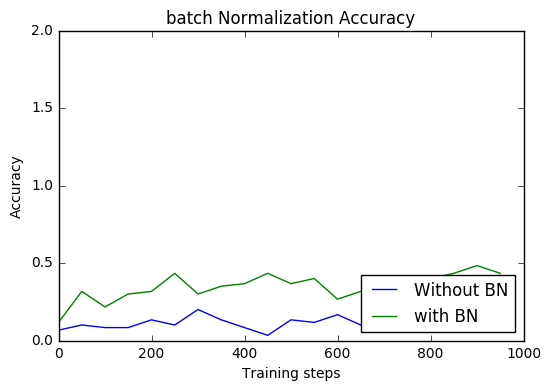

In [15]:
fig ,ax = plt.subplots()

ax.plot(range(0,len(acc)*50 , 50) , acc , label='Without BN')
ax.plot(range(0,len(acc)*50 , 50) ,acc_BN , label='with BN')

ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
ax.set_ylim([0,2])
ax.set_title("batch Normalization Accuracy")
ax.legend(loc=4)
plt.show()
        
        
        

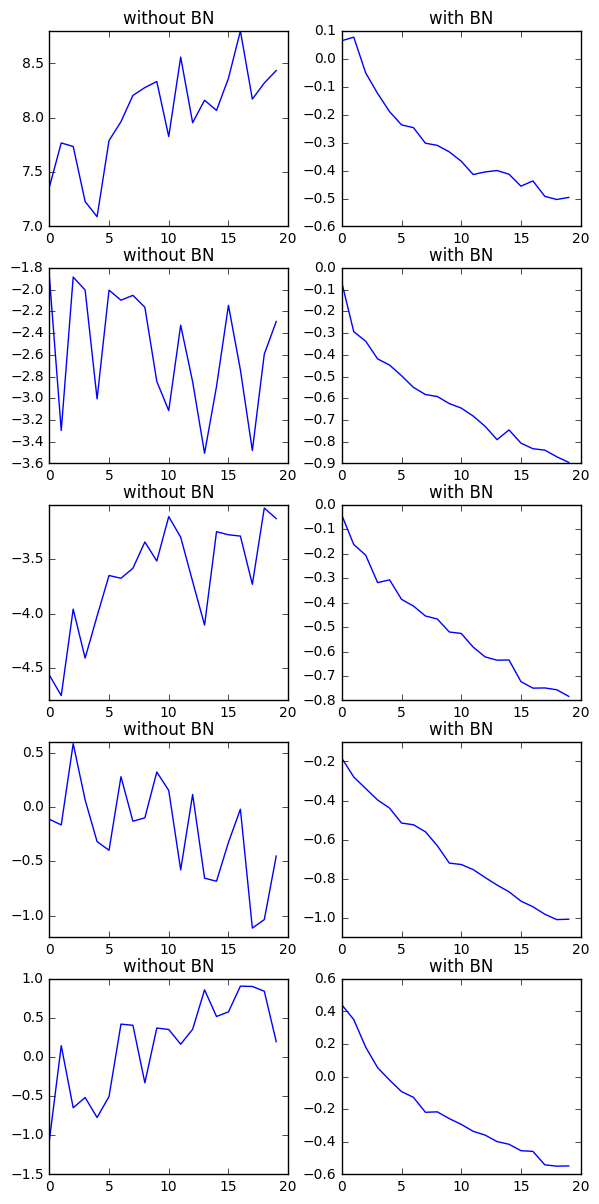

In [16]:

fig ,axes = plt.subplots(5,2 , figsize=(6,12))
fig.tight_layout()

for i , ax  in enumerate(axes):
    ax[0].set_title("without BN")
    ax[1].set_title("with BN")
    ax[0].plot(zs[:,i])
    ax[1].plot(BNs[:,i])

In [17]:
def batch_norm_wrapper(inputs , is_training , decay = 0.999):
    scale=tf.Variable(tf.ones([inputs.get_shape()[-1]]))
    beta =tf.Variable(tf.ones([inputs.get_shape()[-1]]))
    pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]),trainable=False)
    pop_var  = tf.Variable(tf.zeros([inputs.get_shape()[-1]]),trainable=False)
    
    if is_training:
        batch_mean , batch_var = tf.nn.moments(inputs,[0])
        train_mean = tf.assign(pop_mean , pop_mean*decay+batch_mean*(1-decay))
        train_var  = tf.assign(pop_var  , pop_var*decay +batch_var*(1-decay))
        with tf.control_dependencies([train_mean , train_var]):
            return tf.nn.batch_normalization(inputs, batch_mean , batch_var , beta , scale , epsilon)
    else:
        return tf.nn.batch_normalization(inputs , pop_mean , pop_var , beta , scale , epsilon)
    

In [18]:
def build_graph(is_training):


    x_pre=tf.placeholder(tf.float32 , shape=[None,32,32,3])
    x_ = tf.reshape(x_pre , shape=[-1,32*32*3])
    y_=tf.placeholder(tf.float32 , shape=[None , 10])

    w1 = tf.Variable(w1_initial)
    z1 = tf.matmul(x_,w1)
    bn1 = batch_norm_wrapper(z1 , is_training)
    l1 = tf.nn.sigmoid(bn1)

    #layer 2

    w2 = tf.Variable(w2_initial)
    z2 = tf.matmul(l1 , w2)
    bn2 = batch_norm_wrapper(z2 , is_training)
    l2 = tf.nn.sigmoid(bn2)

    w3 = tf.Variable(w3_initial)
    b3 = tf.Variable(tf.zeros([10]))
    y = tf.nn.softmax(tf.matmul(l2 , w3))

    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.arg_max(y ,1) , tf.arg_max(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction , tf.float32))

    return (x_, y_) , train_step , accuracy , y , tf.train.Saver()

In [22]:
tf.reset_default_graph()

(x_,y_) , train_step , accuray , _ , saver = build_graph(is_training=True)
acc=[]
with tf.Session() as ses:
    sess.run(tf.initialize_all_variables())
    for i in range(100000):
        batch_xs , batch_ys = next_batch(60 , train_img , train_lab)
        sess.run(train_step , feed_dict={x_:batch_xs , y_ : batch_ys})
        if i%50 is 0:
            res = sess.run([accuracy],feed_dict={x:mnist.test.images})
            acc.append(res[0])
        saved_model = saver.save(sess, 'temp-bn-save')
print "final_accuracy" , acc[-1]

Instructions for updating:
Use `tf.global_variables_initializer` instead.


ValueError: Fetch argument <tensorflow.python.framework.ops.Operation object at 0x7f650c34be90> cannot be interpreted as a Tensor. (Operation name: "init"
op: "NoOp"
input: "^Variable/Assign"
input: "^Variable_1/Assign"
input: "^Variable_2/Assign"
input: "^Variable_3/Assign"
input: "^Variable_4/Assign"
input: "^Variable_5/Assign"
input: "^Variable_6/Assign"
input: "^Variable_7/Assign"
input: "^Variable_8/Assign"
input: "^Variable_9/Assign"
input: "^Variable_10/Assign"
input: "^Variable_11/Assign"
 is not an element of this graph.)

In [ ]:
tf.reset_default_graph()
(x_,y_),_,accuracy , y , saver = build_graph(is_training=False)
predictions=[]
correct=0
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    saver.restore(sess, saved_model)
    for i in range(100):
        pred , corr = sess.run([tf.arg_max(y,1),accuracy] , feed_dict={x_: test_img , y_:test_lab})
        correct+=corr
        predictions.append(pred[0])
    print ("PREDICTIONS:" , predictions)
    print("ACCURACY",correct/100)